# Example: Mediation analysis and direct effects

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar, Callable

import torch
import torch.nn as nn
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual

## Background: nested counterfactuals



[Direct and indirect effects](https://ftp.cs.ucla.edu/pub/stat_ser/R273-U.pdf)

[Nested counterfactuals](https://proceedings.neurips.cc/paper/2021/hash/36bedb6eb7152f39b16328448942822b-Abstract.html)

## Data

What is the direct effect of deviant peer engagement on substance use disorder? That is, does reduced engagement with deviant peer groups and reduced experimentation with drugs mediate the effect of the family intervention during adolescence on future substance use disorder? For example, we might hypothesize that participation in family intervention during adolescence reduces engagement with deviant peer groups and experimentation with drugs, which in turns reduces the likelihood for substance use disorder in young adulthood.

To explore these questions, we use [a small simulated dataset](https://rdrr.io/cran/intmed/man/substance.html) from the [R package `intmed`](https://cran.r-project.org/web/packages/intmed/index.html), converted to CSV form from [this blog post](https://statsnotebook.io/blog/analysis/mediation/).

The dataset has 553 rows corresponding to (simulated) individuals and six columns, some values of which are missing for some individuals:

`"sub_disorder"`, the outcome variable we will study, is a boolean variable representing whether an individual was diagnosed of substance use disorder in young adulthood. It is the outcome variable we are interested in.

`"fam_int"`, the treatment variable whose effects on `"sub_disorder"` we wish to understand, is a boolean variable representing whether the individual's family participated in family intervention during adolescence.

`"dev_peer"`, a mediator in our analysis, is a boolean variable representing whether the individual was engaged with deviant peer groups.

`"sub_exp"`, another mediator in our analysis, is a boolean variable representing whether the individual experimented with drugs.

`"conflict"`, a covariate in our analysis since it is unaffected causally by `"fam_int"`, is a continuous variable representing level of family conflict.

`"gender"`, another coviariate in our analysis, is a categorical variable representing the individual's gender.

In [2]:
# Let's load the data from the url
DATA_URL = "https://statsnotebook.io/blog/data_management/example_data/substance.csv"

df = pd.read_csv(DATA_URL)
print(f"Number of individuals: {len(df)}")
df = df.dropna()  # for now, ignore rows with missing or invalid data
num_data = len(df)
print(f"Number of individuals without missing values: {num_data}")

data = {
    "conflict": torch.tensor(df["conflict"].values, dtype=torch.float),
    "gender": torch.tensor(df["gender"].values == "Male", dtype=torch.float),
    "fam_int": torch.tensor(df["fam_int"].values, dtype=torch.float),
    "dev_peer": torch.tensor(df["dev_peer"].values, dtype=torch.float),
    "sub_exp": torch.tensor(df["sub_exp"].values, dtype=torch.float),
    "sub_disorder": torch.tensor(df["sub_disorder"].values, dtype=torch.float),
}
covariates = {"conflict": data["conflict"], "gender": data["gender"]}
mediators = {"dev_peer": data["dev_peer"], "sub_exp": data["sub_exp"]}

# Show the data
df.head()

Number of individuals: 553
Number of individuals without missing values: 410


,gender,conflict,dev_peer,sub_exp,fam_int,sub_disorder
0,Female,3.000000,1.0,0.0,0.0,0.0
1,Female,3.000000,1.0,1.0,0.0,0.0
2,Male,4.000000,1.0,1.0,0.0,1.0
4,Female,2.666667,1.0,1.0,0.0,0.0
5,Female,2.000000,1.0,1.0,0.0,0.0


## Model

We can represent the causal assumptions discussed above as a Pyro model: 

In [3]:
def abstract_model(f_fam_int: Callable, f_dev_peer: Callable, f_sub_exp: Callable, f_sub_disorder: Callable):
    
    conflict = pyro.sample("conflict", dist.LogNormal(0, 1))
    gender = pyro.sample("gender", dist.Bernoulli(0.5))
    
    logits_fam_int = f_fam_int(conflict, gender)
    fam_int = pyro.sample("fam_int", dist.Bernoulli(logits=logits_fam_int))
    
    logits_dev_peer = f_dev_peer(conflict, gender, fam_int)
    dev_peer = pyro.sample("dev_peer", dist.Bernoulli(logits=logits_dev_peer))
    
    logits_sub_exp = f_sub_exp(conflict, gender, fam_int)
    sub_exp = pyro.sample("sub_exp", dist.Bernoulli(logits=logits_sub_exp))
    
    logits_sub_disorder = f_sub_disorder(conflict, gender, dev_peer, sub_exp)
    sub_disorder = pyro.sample("sub_disorder", dist.Bernoulli(logits=logits_sub_disorder))
    
    return sub_disorder

We can use learnable linear functions to represent the abstract mechanisms in a surrogate causal model:

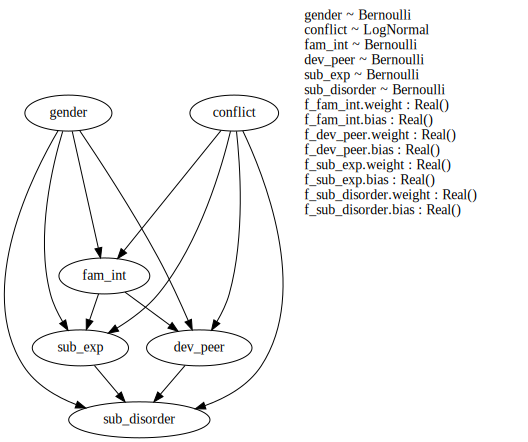

In [4]:
class CausalModel(PyroModule):
    def __init__(self):
        super().__init__()
        self.f_fam_int = PyroModule[nn.Linear](2, 1)
        self.f_dev_peer = PyroModule[nn.Linear](3, 1)
        self.f_sub_exp = PyroModule[nn.Linear](3, 1)
        self.f_sub_disorder = PyroModule[nn.Linear](4, 1)

    def forward(self) -> torch.Tensor:
        gender = pyro.sample("gender", dist.Bernoulli(0.5))
        conflict = pyro.sample("conflict", dist.LogNormal(0, 1))
        
        covariates = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None]
        ), dim=-1)
    
        logits_fam_int = self.f_fam_int(covariates)[..., 0]
        fam_int = pyro.sample("fam_int", dist.Bernoulli(logits=logits_fam_int))
        
        covariates_and_treatment = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None], fam_int[..., None]
        ), dim=-1)
        
        logits_dev_peer = self.f_dev_peer(covariates_and_treatment)[..., 0]
        dev_peer = pyro.sample("dev_peer", dist.Bernoulli(logits=logits_dev_peer))

        logits_sub_exp = self.f_sub_exp(covariates_and_treatment)[..., 0]
        sub_exp = pyro.sample("sub_exp", dist.Bernoulli(logits=logits_sub_exp))
        
        covariates_and_mediators = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None], dev_peer[..., None], sub_exp[..., None]
        ), dim=-1)

        logits_sub_disorder = self.f_sub_disorder(covariates_and_mediators)[..., 0]
        sub_disorder = pyro.sample("sub_disorder", dist.Bernoulli(logits=logits_sub_disorder))

        return sub_disorder

surrogate_model = CausalModel()
pyro.render_model(surrogate_model, render_distributions=True, render_params=True)

## Query: natural direct effect (NDE)

The natural direct effect

$$NDE ( Y; x, x' ) = \mathbb{E} [ Y_{X=x', Z=Z_{X=x}} - \mathbb{E} [ Y_{X=x} ] ]$$

In [5]:
def direct_effect(model: Callable, X: str, Z: str) -> Callable:
    def wrapper(x, x_prime):
        with MultiWorldCounterfactual(-2):
            ys = do(actions={X: x})(
                do(actions={X: x_prime})(
                    do(actions={Z: lambda Z_: Z_})(
                        pyro.plate("data", size=x.shape[0], dim=-1)(
                            model))))()
        
            return ys
    return wrapper

We can apply this directly to the causal model defined above to get a new model representing the joint distribution over all factual and counterfactual variables necessary to estimate the NDE:

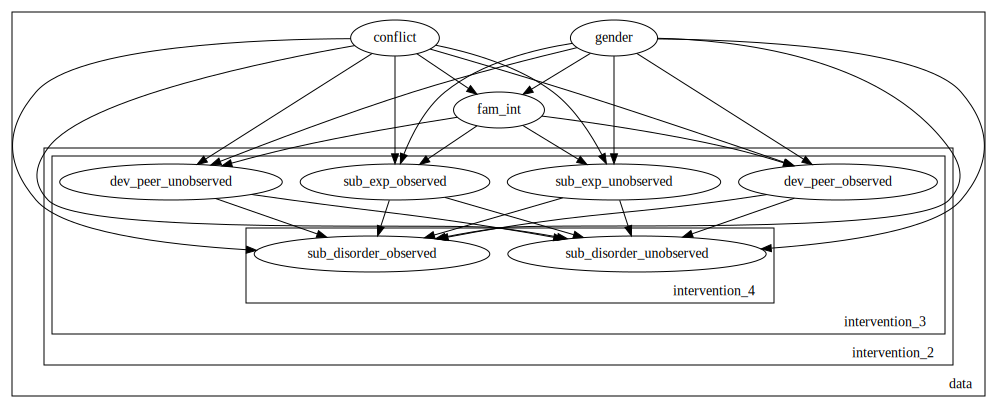

In [6]:
x0 = data["fam_int"].new_full((num_data,), 0.)
x1 = data["fam_int"].new_full((num_data,), 1.)

query_model = direct_effect(surrogate_model, "fam_int", "sub_exp")

pyro.render_model(query_model, (x0, x1))

A quantity complementary to the direct effect is the indirect effect:

$$IE ( Y; x, x' ) = \mathbb{E} [ Y_{X=x', Z=Z_{X=x}} - \mathbb{E} [ Y_{X=x} ] ]$$

Interestingly, the indirect effect is also computable from the same query operation under `MultiWorldCounterfactual`.

# Inference

Before attempting to compute the natural direct effect, we first learn the model's parameters.

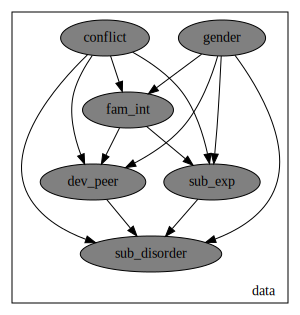

In [7]:
conditioned_model = pyro.condition(data=data)(
    pyro.plate("data", size=num_data, dim=-1)(
        surrogate_model
    )
)

pyro.render_model(conditioned_model)

In [8]:
pyro.clear_param_store()

guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = pyro.infer.SVI(conditioned_model, guide, adam, loss=pyro.infer.Trace_ELBO())
num_iterations = 1500
for j in range(num_iterations):
    loss = svi.step()
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j, loss / len(data)))

[iteration 0000] loss: 368.0111
[iteration 0100] loss: 326.8923
[iteration 0200] loss: 325.8086
[iteration 0300] loss: 325.3414
[iteration 0400] loss: 325.1151
[iteration 0500] loss: 325.0236
[iteration 0600] loss: 324.9916
[iteration 0700] loss: 324.9818
[iteration 0800] loss: 324.9792
[iteration 0900] loss: 324.9786
[iteration 1000] loss: 324.9785
[iteration 1100] loss: 324.9785
[iteration 1200] loss: 324.9785
[iteration 1300] loss: 324.9785
[iteration 1400] loss: 324.9785


Now we can use the expanded model defined previously to get the natural direct effect:

In [12]:
conditioned_query_model = pyro.condition(data=covariates)(
    pyro.condition(data={"fam_int": data["fam_int"]})(  # TODO remove this line which has no effect on inference
        query_model))

discrete_posterior = pyro.infer.infer_discrete(first_available_dim=-6)(
    pyro.infer.config_enumerate()(
        conditioned_query_model))

predictive = pyro.infer.Predictive(conditioned_query_model, guide=discrete_posterior, num_samples=500)
predictive_samples = predictive(x0, x1)

ys_all = predictive_samples["sub_disorder_unobserved"]
ys_xprime = ys_all[..., 1, 1, 0, :]  # TODO is this indexing into the right world?
ys_x = ys_all[..., 0, 0, 1, :]  # TODO is this indexing into the right world?
individual_NDE_samples = ys_xprime - ys_x

In [10]:
predictive_samples.keys()

dict_keys(['dev_peer_observed', 'dev_peer_unobserved', 'sub_exp_observed', 'sub_exp_unobserved', 'sub_disorder_observed', 'sub_disorder_unobserved', 'gender', 'conflict', 'fam_int'])

# Evaluation

We can compute the natural direct effect from samples of the posterior distribution over the potential outcomes:

In [ ]:
import matplotlib.pyplot as plt

individual_NDE_mean = torch.mean(individual_NDE_samples, dim=0)
NDE_samples = torch.mean(individual_NDE_samples, dim=-1)  # avg over datapoints
NDE_mean = torch.mean(NDE_samples, dim=0)  # avg over posterior samples
print(NDE_mean)
plt.hist(individual_NDE_mean.detach().cpu().numpy(), bins=20)